#### Configuración del ambiente

In [7]:
#Intsalaciones necesarias 
#pip install opencv-python

In [3]:
#Importar librerias
import os
import cv2
from keras.models import load_model   
from PIL import Image, ImageOps  
import numpy as np
import statistics

In [4]:
os.getcwd()
os.chdir("C:\\Users\\aduran\\OneDrive - Asesoftware S.A.S\\Escritorio\\personal\\Transmilenio\\Videos")
os.getcwd()

'C:\\Users\\aduran\\OneDrive - Asesoftware S.A.S\\Escritorio\\personal\\Transmilenio\\Videos'

In [4]:
os.listdir()

['delictivo_1.mp4',
 'delictivo_2.mp4',
 'delictivo_3.mp4',
 'delictivo_5.mp4',
 'delictivo_6.mp4',
 'normal_1.mp4',
 'normal_2.mp4',
 'normal_3.mp4',
 'normal_4.mp4',
 'normal_5.mp4',
 'Videos delictivos',
 'Videos normales']

In [9]:
for i in range(1,5):
    # Open the video file
    cap = cv2.VideoCapture(f'normal_{i}.mp4')

    # Initialize a frame counter
    count = 0

    # Loop through the frames
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()

        # If the frame was not read successfully, break the loop
        if not ret:
            break

        # Save the frame as an image
        cv2.imwrite(f'normal_{i}_frame_{count}.jpg', frame)

        # Increment the frame counter
        count += 1

    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()

### Modelo Identificación de objetos y conductas

In [1]:
def modelo_objetos_actitudes(frame):
    # Desactivar notación científica
    np.set_printoptions(suppress=True)

    # Cargar el modelo
    model = load_model("keras_model.h5", compile=False)

    # Cargar los labels
    class_names = open("labels.txt", "r").readlines()

    # Crear el array para introducirlo en el modelo keras
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    image = Image.open(str(frame)).convert("RGB")

    # Cambiar el tamaño de la imagen a 224x224 cortando desde el centro
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # Convertir la imagen en numpy array
    image_array = np.asarray(image)

    # Normalizar la imagen
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Cargar la imagen como array
    data[0] = normalized_image_array

    # Predicciones del modelo
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]

    return class_name[2:], confidence_score

### Convertir video a frames

In [3]:
def video_to_frames(video,modelo):
    # Cargar el video 
    cap = cv2.VideoCapture(str(video+'.mp4'))
    
    #Extrae la cantidad de frames dependiendo de la longitud del video, la altura y ancho del video 
    video_fps = cap.get(cv2.CAP_PROP_FPS),
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    # Divide el video en frames
    currentframe=0
    clases=[]
    clases_score=[]
    ret, frame = cap.read()
    while currentframe<10:
        ret,frame=cap.read()
        if ret:
            name='frame'+str(currentframe)+'.jpg'
            cv2.imwrite(name,frame)
            currentframe +=1
            #Evalua el modelo keras con el frame extraido
            class_name, confidence_score = modelo(name)
            clases_score.append([class_name, confidence_score])
            clases.append(class_name)
        else:
            break    
    cap.release()
    cv2.destroyAllWindows()
    return set(clases), clases_score

### Extraer clase y porcentaje de confianza

In [4]:
#Extrae las clases encontradas en los frames del video y encuentra la probabilidad promedio de cada una de ellas
def class_confidence(lista_clases,clases):
    confidence={}
    for x in clases:
        clase1=[]
        for i in lista_clases:
            if i[0]==x:
                clase1.append(i[1])
        confidence[x.replace('\n','')]=[statistics.mean(clase1),max(clase1)]
    print (confidence)   

#### Prueba objetos

In [7]:
clases, clases_score=video_to_frames('video_transmilenio_1',modelo_objetos_actitudes)

1/1 [==============================] - 1s 513ms/step


In [8]:
class_confidence(clases_score,clases)

{'Tapabocas': [0.5159257, 0.52594066], 'Gorra': [0.5934783, 0.68958974]}


#### Modelo identificación día-noche

In [9]:
def modelo_dia_noche(frame):
    # Desactivar notación científica
    np.set_printoptions(suppress=True)

    # Cargar el modelo
    model = load_model("dia-noche.h5", compile=False)

    # Cargar los labels
    class_names = open("labels dia-noce.txt", "r").readlines()

    # Crear el array para introducirlo en el modelo keras
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    image = Image.open(str(frame)).convert("RGB")

    # Cambiar el tamaño de la imagen a 224x224 cortando desde el centro
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # Convertir la imagen en numpy array
    image_array = np.asarray(image)

    # Normalizar la imagen
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Cargar la imagen como array
    data[0] = normalized_image_array

    # Predicciones del modelo
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]

    return class_name[2:], confidence_score

### Prueba día y noche

In [11]:
clases, clases_score=video_to_frames('video_transmilenio_1',modelo_dia_noche)

1/1 [==============================] - 1s 502ms/step


In [12]:
class_confidence(clases_score,clases)

{'día': [0.99548465, 0.99913967]}


#### YOLO

In [16]:
import cv2
import numpy as np

# Load YOLOv3 weights
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load video
cap = cv2.VideoCapture("delictivo_1.mp4")

# Define the output codec and video writer
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter("output_video_final.mp4", fourcc, 30, (640, 480))

# Loop through each video frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess the video frame
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    
    # Set the input to the YOLO model and run object detection
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = ["yolo_82", "yolo_94", "yolo_106"]
    outputs = net.forward(output_layers)
    
    # Loop through each detected object
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Get the coordinates of the bounding box
                center_x = int(detection[0] * 640)
                center_y = int(detection[1] * 480)
                width = int(detection[2] * 640)
                height = int(detection[3] * 480)
                x = center_x - width // 2
                y = center_y - height // 2
                
                # Draw the bounding box
                cv2.rectangle(frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
    
    # Write the output frame to the output video
    out.write(frame)

# Release the video capture and video writer
cap.release()
out.release()



#### Cargue de base estructurada - Hurtos en el transporte público 

In [66]:
import pandas as pd

df = pd.read_csv('hurto_a_persona_transporte_publico.csv', encoding='latin1', sep=';').fillna('Sin dato')


In [67]:
df

,sexo,edad,medio_transporte,conducta,modalidad,conducta_especial,arma_medio,nombre_barrio,lugar,bien,categoria_bien,grupo_bien,color,Tapabocas,Capuchas,Gorras,Actitud_nerviosa,llena_vacia,dia_noche,Robo
0,Hombre,35,Transmilenio,Hurto a persona,Cosquilleo,Sin dato,No,Buenavista,EstaciÃ³n del Transmilenio,Billetera,Prendas de vestir y accesorios,MercancÃ­a,Sin dato,si,si,si,si,llena,dia,si
1,Hombre,35,Transmilenio,Hurto a persona,Cosquilleo,Sin dato,No,El Codito,EstaciÃ³n del Transmilenio,CÃ©dula,Documentos,MercancÃ­a,Sin dato,si,si,si,si,llena,dia,si
2,Hombre,30,Transmilenio,Hurto a persona,Cosquilleo,De celular,No,Los Laureles,EstaciÃ³n del Transmilenio,Celular,TecnologÃ­a,MercancÃ­a,Negro,si,si,si,si,llena,dia,si
3,Hombre,35,Transmilenio,Hurto a persona,Cosquilleo,De celular,No,El Redil,EstaciÃ³n del Transmilenio,Celular,TecnologÃ­a,MercancÃ­a,Negro,si,si,si,si,llena,dia,si
4,Mujer,36,Transmilenio,Hurto a persona,Cosquilleo,No,No,Babilonia,EstaciÃ³n del Transmilenio,CÃ©dula,Documentos,MercancÃ­a,Sin dato,si,si,si,si,llena,dia,si
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10493,Mujer,24,Transmilenio,Sin dato,Sin dato,Sin dato,Sin dato,Los Laureles,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,si,si,no,no,llena,dia,no
10494,Mujer,41,Transmilenio,Sin dato,Sin dato,Sin dato,Sin dato,El Redil,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,no,si,si,si,llena,noche,no
10495,Hombre,13,Transmilenio,Sin dato,Sin dato,Sin dato,Sin dato,La Cita,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,no,si,no,si,vacia,dia,no
10496,Mujer,30,Transmilenio,Sin dato,Sin dato,Sin dato,Sin dato,Santandersito,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,si,si,no,no,vacia,dia,no


#### Entrenamiento de modelos de clasificación binaria 

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


# Convert non-numerical columns to numerical
for column in df.select_dtypes(include=['object']):
    df[column] = pd.factorize(df[column])[0]

# Replace missing values with the mean
df.fillna(df.mean(), inplace=True)

# Split data into train/test/validation sets
train_size = 0.6
val_size = 0.2
test_size = 0.2
assert train_size + val_size + test_size == 1  # Ensure sizes sum to 1

X = df.drop(columns=['Robo'])
y = df['Robo']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=42)

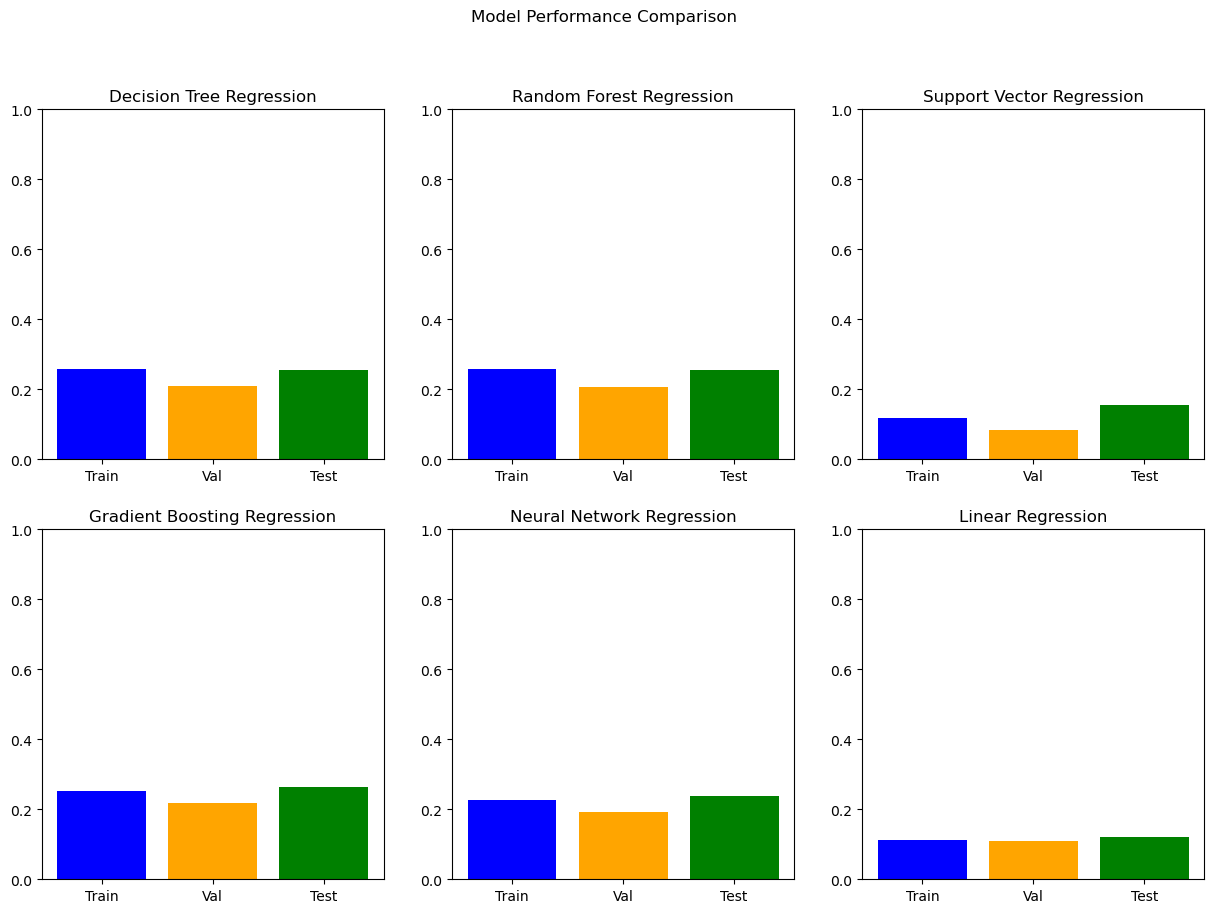

Best model: Gradient Boosting Regression
Test R2: 0.265
Test RMSE: 0.428


In [14]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# define models
models = [
    ('Decision Tree Regression', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regression', RandomForestRegressor(random_state=42)),
    ('Support Vector Regression', SVR()),
    ('Gradient Boosting Regression', GradientBoostingRegressor(random_state=42)),
    ('Neural Network Regression', MLPRegressor(random_state=42)),
    ('Linear Regression', LinearRegression())
]

# train and evaluate models
results = {}
for name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    
    y_val_pred = pipeline.predict(X_val)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    
    y_test_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    results[name] = {'Train R2': train_r2, 'Train RMSE': train_rmse,
                     'Val R2': val_r2, 'Val RMSE': val_rmse,
                     'Test R2': test_r2, 'Test RMSE': test_rmse}

# plot results
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Performance Comparison')

for i, (name, _) in enumerate(models):
    row, col = i // 3, i % 3
    ax[row, col].bar(['Train', 'Val', 'Test'],
                     [results[name]['Train R2'], results[name]['Val R2'], results[name]['Test R2']],
                     color=['blue', 'orange', 'green'])
    ax[row, col].set_ylim(0, 1)
    ax[row, col].set_title(name)

plt.show()

# print best model
best_model = max(results.items(), key=lambda x: x[1]['Test R2'])
print(f"Best model: {best_model[0]}")
print(f"Test R2: {best_model[1]['Test R2']:.3f}")
print(f"Test RMSE: {best_model[1]['Test RMSE']:.3f}")

